# Prueba del modelo de Ising con el código que vi en github de @rodrigolece

In [1]:
export MicroEstado, edo_aleatorio, energia_total, magnetizacion_total, simulacion_montecarlo
export microEstados_montecarlo
import Base.show
using LinearAlgebra
using PyPlot

using PyCall
np = pyimport("numpy")

PyObject <module 'numpy' from '/home/rogve98/.julia/conda/3/lib/python3.9/site-packages/numpy/__init__.py'>

In [2]:
struct MicroEstado
    σ::Array{Int,2}
	# Vamos a suponer que todas las configuraciones son cuadradas
    L::Int
    frio::Array{Int,2}
end

In [3]:
show(io::IO, m::MicroEstado) = print(io, m.σ)

show (generic function with 308 methods)

In [4]:
function edo_aleatorio(L::Int)
    σ = ones(Int, (L,L))
    for i in 1:L^2
        if rand() <= 0.5
			σ[i] = -1
        end
	end
    frio = ones(Int,L,L)
    MicroEstado(σ,L,frio)
end

function voltea_espin!(m::MicroEstado, i::Int, j::Int,conf::String)
    if conf == "caliente"
        m.σ[i,j] *= -1
    elseif conf == "fria"
        m.frio[i,j] *= -1
    end
end

function energia_ij(m::MicroEstado, i::Int, j::Int,conf::String)
    L = m.L
    if conf == "caliente"
        -m.σ[i,j]*(m.σ[mod1(i-1,L),j] + m.σ[mod1(i+1,L),j] + m.σ[i,mod1(j-1,L)] + m.σ[i,mod1(j+1,L)])
    elseif conf == "fria"
        -m.frio[i,j]*(m.frio[mod1(i-1,L),j]+m.frio[mod1(i+1,L),j]+m.frio[i,mod1(j-1,L)]+m.frio[i,mod1(j+1,L)])
        #-m.frio[i,j]*(m.frio[mod1(i-1,L),j]+m.frio[mod1(i+1,L),j]+m.frio[i,mod1(j-1,L)]+m.frio[i,mod1(j+1,L)])
    end
end
        

energia_ij (generic function with 1 method)

In [5]:
function energia_total(m::MicroEstado,conf::String)
	out = 0.
    for i in 1:m.L, j in 1:m.L
		out += energia_ij(m,i,j,conf)
    end
    out
end

energia_total (generic function with 1 method)

In [6]:
function propone_cambio(m::MicroEstado, β::Float64,conf::String)
    i, j = rand(1:m.L), rand(1:m.L)  # Es más rápido que rand(1:m.L, 2)
	ΔE = -2*energia_ij(m, i, j, conf)

	ΔE, i, j
end

propone_cambio (generic function with 1 method)

In [7]:
function paso_montecarlo!(m::MicroEstado, β::Float64,conf::String)
	aceptado = false

	while aceptado == false
		ΔE, i, j = propone_cambio(m, β,conf)

		# El parámetro de aceptación
		α = min(1., exp(-β*ΔE))

		if rand() < α
			aceptado = true
			ΔM = -2*m.σ[i,j]
			voltea_espin!(m, i, j,conf)
			return ΔE, ΔM
		end
    end
end

paso_montecarlo! (generic function with 1 method)

In [8]:
function magnetizacion_total(m::MicroEstado,conf::String)
    if conf == "caliente"
        sum(m.σ)
    elseif conf == "fria"
        sum(m.frio)
    end
end

magnetizacion_total (generic function with 1 method)

In [9]:
    function simulacion_montecarlo(L::Int, T, num_pasos::Int,conf)
        β = 1/T
        m = edo_aleatorio(L)

        ener = zeros(num_pasos)
        ener[1] = energia_total(m,conf)
        mag = zeros(num_pasos)
        mag[1] = magnetizacion_total(m,conf)

        for i in 1:num_pasos-1
            ΔE, ΔM = paso_montecarlo!(m, β,conf)
            ener[i+1] = ener[i] + ΔE
            mag[i+1] = mag[i] + ΔM
        end

        return ener, mag, m
    end

simulacion_montecarlo (generic function with 1 method)

In [10]:
m = edo_aleatorio(50)
energia_total(m,"fria")

-10000.0

In [11]:
    #con 1millon jala en 3 seegundos
    @time begin
    L=100
    T=0.5
    num_pasos = 100000
    ener, mag, m = simulacion_montecarlo(L::Int, T, num_pasos::Int,"caliente")
    end

  0.411231 seconds (257.27 k allocations: 15.891 MiB, 28.15% compilation time)


([-304.0, -308.0, -308.0, -308.0, -308.0, -312.0, -320.0, -324.0, -324.0, -324.0  …  -19632.0, -19632.0, -19632.0, -19632.0, -19632.0, -19632.0, -19632.0, -19632.0, -19632.0, -19632.0], [-82.0, -80.0, -78.0, -76.0, -74.0, -76.0, -78.0, -80.0, -82.0, -80.0  …  2414.0, 2412.0, 2410.0, 2412.0, 2410.0, 2412.0, 2414.0, 2416.0, 2414.0, 2416.0], [1 1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … 1 1])

In [12]:
#enerF, magF, mF = simulacion_montecarlo(L::Int, T, num_pasos::Int,"fria")

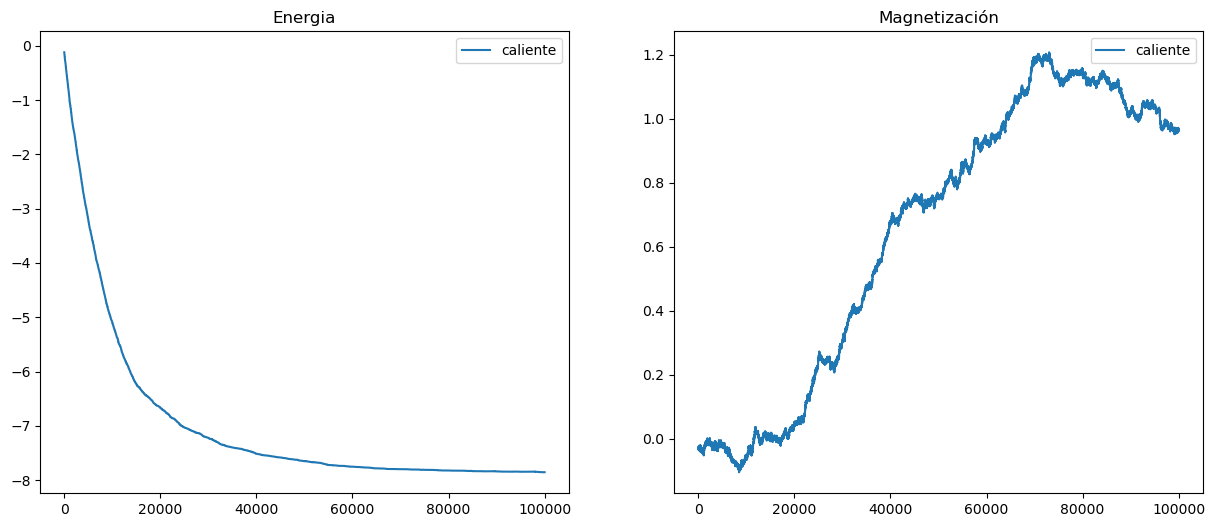

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/rogve98/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


PyObject <matplotlib.legend.Legend object at 0x7fad30348580>

In [13]:
figure(figsize=(15,6))

subplot(1,2,1)
#plot(enerF,label ="fria")
plot(ener/50^2,label="caliente")
title("Energia")
legend()

subplot(1,2,2)
#plot(magF,label="fria")
plot(mag/50^2,label = "caliente")
title("Magnetización")
legend()

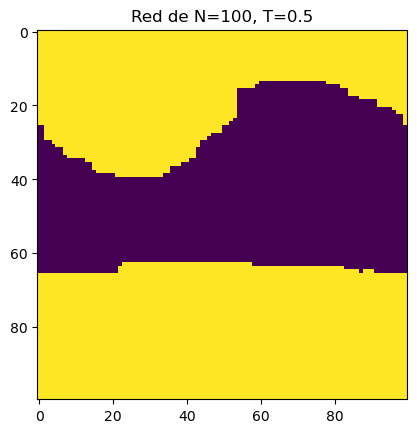

In [14]:
imshow(m.σ)
title("Red de N=100, T=0.5")
savefig("T01.jpg")

In [15]:
function microEstados_montecarlo(L::Int, T, num_pasos::Int,conf)
	β = 1/T
	m = edo_aleatorio(L)

	out = Array{Int,2}[copy(m.σ)]
	sizehint!(out, num_pasos)

	for i in 1:num_pasos-1
		paso_montecarlo!(m, β,conf)
		push!(out, copy(m.σ))
	end

	out
end

microEstados_montecarlo (generic function with 1 method)

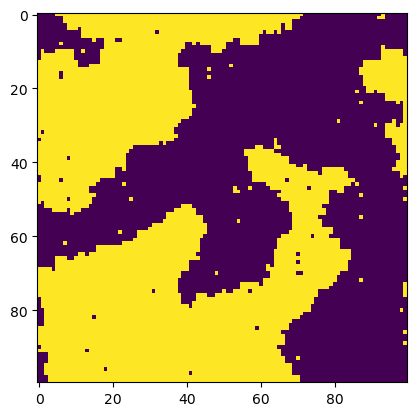

PyObject <matplotlib.image.AxesImage object at 0x7facee766a30>

In [16]:
imshow(microEstados_montecarlo(100,1.5,100000,"caliente")[end])